In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from dataset.dataset import DepictionDataset
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm, trange
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
from torch.utils.data import random_split, DataLoader
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import torchvision

device = torch.device('cpu')
try:
    import torch_directml
    device = torch_directml.device()
    device = torch.device('cpu')
except:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}") 

# resnet tested on padded dataset
model_path        = r"C:\Users\linus\Documents\models\instanceRotation\ResNet34_57perc_20230824_16-49-09.pth"
dataset_base_path = r"C:\Users\linus\Documents\Datasets\InstanceRotation\paddedWithSpace"
batch_size=256

model = torch.load(model_path, map_location=torch.device('cpu'))

whole_data = DepictionDataset(annotations_file=f"{dataset_base_path}/paddedWithSpaceLabels.csv",
                            img_dir=f"{dataset_base_path}/trainSet", 
                            img_size=(224, 224))

whole_data.set_mean((0.7826,)) 
whole_data.set_std((0.2941,))

train_split = 0.5
test_split = 1-train_split


# make the test data from the dataset
train_data, test_data = random_split(dataset=whole_data,
                                     lengths=[int(len(whole_data)*train_split), int(len(whole_data)*test_split)+1],
                                     generator=torch.Generator().manual_seed(442))

test_dataloader  = DataLoader(test_data, batch_size=batch_size)


model = model.to(device)
# model.eval()
print(f"test_data size: {len(test_data)}")

[INFO] Using device: cpu
test_data size: 16608


In [7]:
y_true = []
y_predctions = []
with torch.no_grad():
    correct = total = 0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)       
        output = model(images)
        # _, prediction = torch.max(output.data, 1)
        y_true.extend(labels.tolist())
        y_predctions.extend(output.tolist())
        # total += label.size(0)
        # correct += (prediction == label).sum().item()
y_predictions = y_predctions

  0%|          | 0/65 [00:00<?, ?it/s]

In [9]:
y_pred = [i.index(max(i)) for i in y_predctions]

In [10]:
def transform_tensor_back(image_tensor: torch.Tensor, label: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if label < 4 else True
    if label == 0 or label == 4:
        angle = False
    elif label == 1 or label == 5:
        angle = 270
    elif label == 2 or label == 6:
        angle = 180
    elif label == 3 or label == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    return image_tensor
def transform_tensor_forward(image_tensor: torch.Tensor, prediction: int) -> torch.Tensor:
    """Transforms a tensor based on a prediction. Transform "back" to the "original" image (label=0)"""
    flip = False if prediction < 4 else True
    if prediction == 0 or prediction == 4:
        angle = False
    elif prediction == 1 or prediction == 5:
        angle = 270
    elif prediction == 2 or prediction == 6:
        angle = 180
    elif prediction == 3 or prediction == 7:
        angle = 90
    image_tensor = torchvision.transforms.functional.vflip(image_tensor) if flip is not False else image_tensor
    image_tensor = torchvision.transforms.functional.rotate(image_tensor, angle) if angle is not False else image_tensor
    return image_tensor

def get_ambiguity_score(image, return_stats: False) -> float:
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    embedding1 = model(image)
    prediction = torch.argmax(embedding1, dim=1)
    
    reoriented_image = transform_tensor_back(image, prediction)
    
    embedding2 = model(reoriented_image)
    
    embedding1, embedding2 = embedding1.detach().numpy(), embedding2.detach().numpy()
    similarity = cosine_similarity(embedding1, embedding2)
    if return_stats: return similarity[0][0], (embedding1,  embedding2), reoriented_image
    else: return similarity[0][0]
    
def compare_answer_with_original(image, correct_label):
    if isinstance(image, np.ndarray):
        image = cv2.resize(image, (224, 224))
        image = image.astype("float32") / 255.0
        image = np.transpose(image, (2, 0,  1))
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
    image = image[0]
    image = image.unsqueeze(0)
    # rotate image to original orientation according to label
    original_orientation = transform_tensor_back(image, correct_label)
    original_embedding = model(original_orientation)
    prediction = torch.argmax(original_embedding, dim=1)
    
    # rotate image to predicted orientation
    predicted_orientation = transform_tensor_forward(original_orientation, prediction)
    predicted_embedding = model(predicted_orientation)
    
    original_embedding, predicted_embedding = original_embedding.detach().numpy(), predicted_embedding.detach().numpy()
    similarity = cosine_similarity(original_embedding, predicted_embedding)
    return similarity[0][0], (original_embedding, predicted_embedding), (image, predicted_orientation)
    
    

In [11]:
def get_embedding(image):
    image = image.unsqueeze(0)
    embedding = model(image)
    return embedding

def get_prediction_from_embedding(embedding):
    prediction = torch.argmax(embedding, dim=1)
    return prediction

def rotate_to_corr_orientation(image, ground_truth_label):
    rotated_back = torchvision.transforms.functional.rotate(image, int(90*(ground_truth_label%4))) # 0: -0°, 1: -90°, 2: -180°, 3: -270° ...
    flipped_back = torchvision.transforms.functional.hflip(rotated_back) if ground_truth_label > 3 else rotated_back
    return flipped_back

def rotate_to_pred_orientation(image, prediction):
    flipped = torchvision.transforms.functional.hflip(image) if prediction > 3 else image
    rotated = torchvision.transforms.functional.rotate(flipped, int(-90*(prediction%4))) # 0: 0°, 1: 90°, 2: 180°, 3: 270° ...
    return rotated

def compare_embeddings(embedding1, embedding2):
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

def inference_evaluation(testdata, index):
    input_image, true_label = testdata[index]
    original_embedding = model(input_image.unsqueeze(0))
    prediction = get_prediction_from_embedding(original_embedding)
    correct_oriented_image = rotate_to_corr_orientation(input_image, true_label)
    rotated_image = rotate_to_pred_orientation(correct_oriented_image, prediction)
    rotated_embedding = model(rotated_image.unsqueeze(0))    
    original_embedding, rotated_embedding = original_embedding.detach().numpy(), rotated_embedding.detach().numpy()
    similarity = compare_embeddings(original_embedding, rotated_embedding)

    return similarity, original_embedding[0], rotated_embedding[0], input_image.numpy()[0,:,:], rotated_image.numpy()[0,:,:], true_label, int(prediction)

In [12]:
print([0-90*(i%4) for i in range(8)])

[0, -90, -180, -270, 0, -90, -180, -270]


In [13]:
y_pred_corrected = y_pred.copy()
not_true = []
wrongly_predicted = []
for i in trange(len(y_pred)):
    if y_pred[i] != y_true[i]:
        similarity, original_embedding, rotated_embedding, input_image, rotated_image, true_label, prediction = inference_evaluation(test_data, i)
        eval_obj = {"similarity": similarity,
                    "original_embedding": original_embedding, 
                    "rotated_embedding": rotated_embedding, 
                    "input_image": input_image, 
                    "rotated_image": rotated_image,
                    "true_label": true_label,
                    "prediction": prediction}
        not_true.append(eval_obj)

  0%|          | 0/16608 [00:00<?, ?it/s]

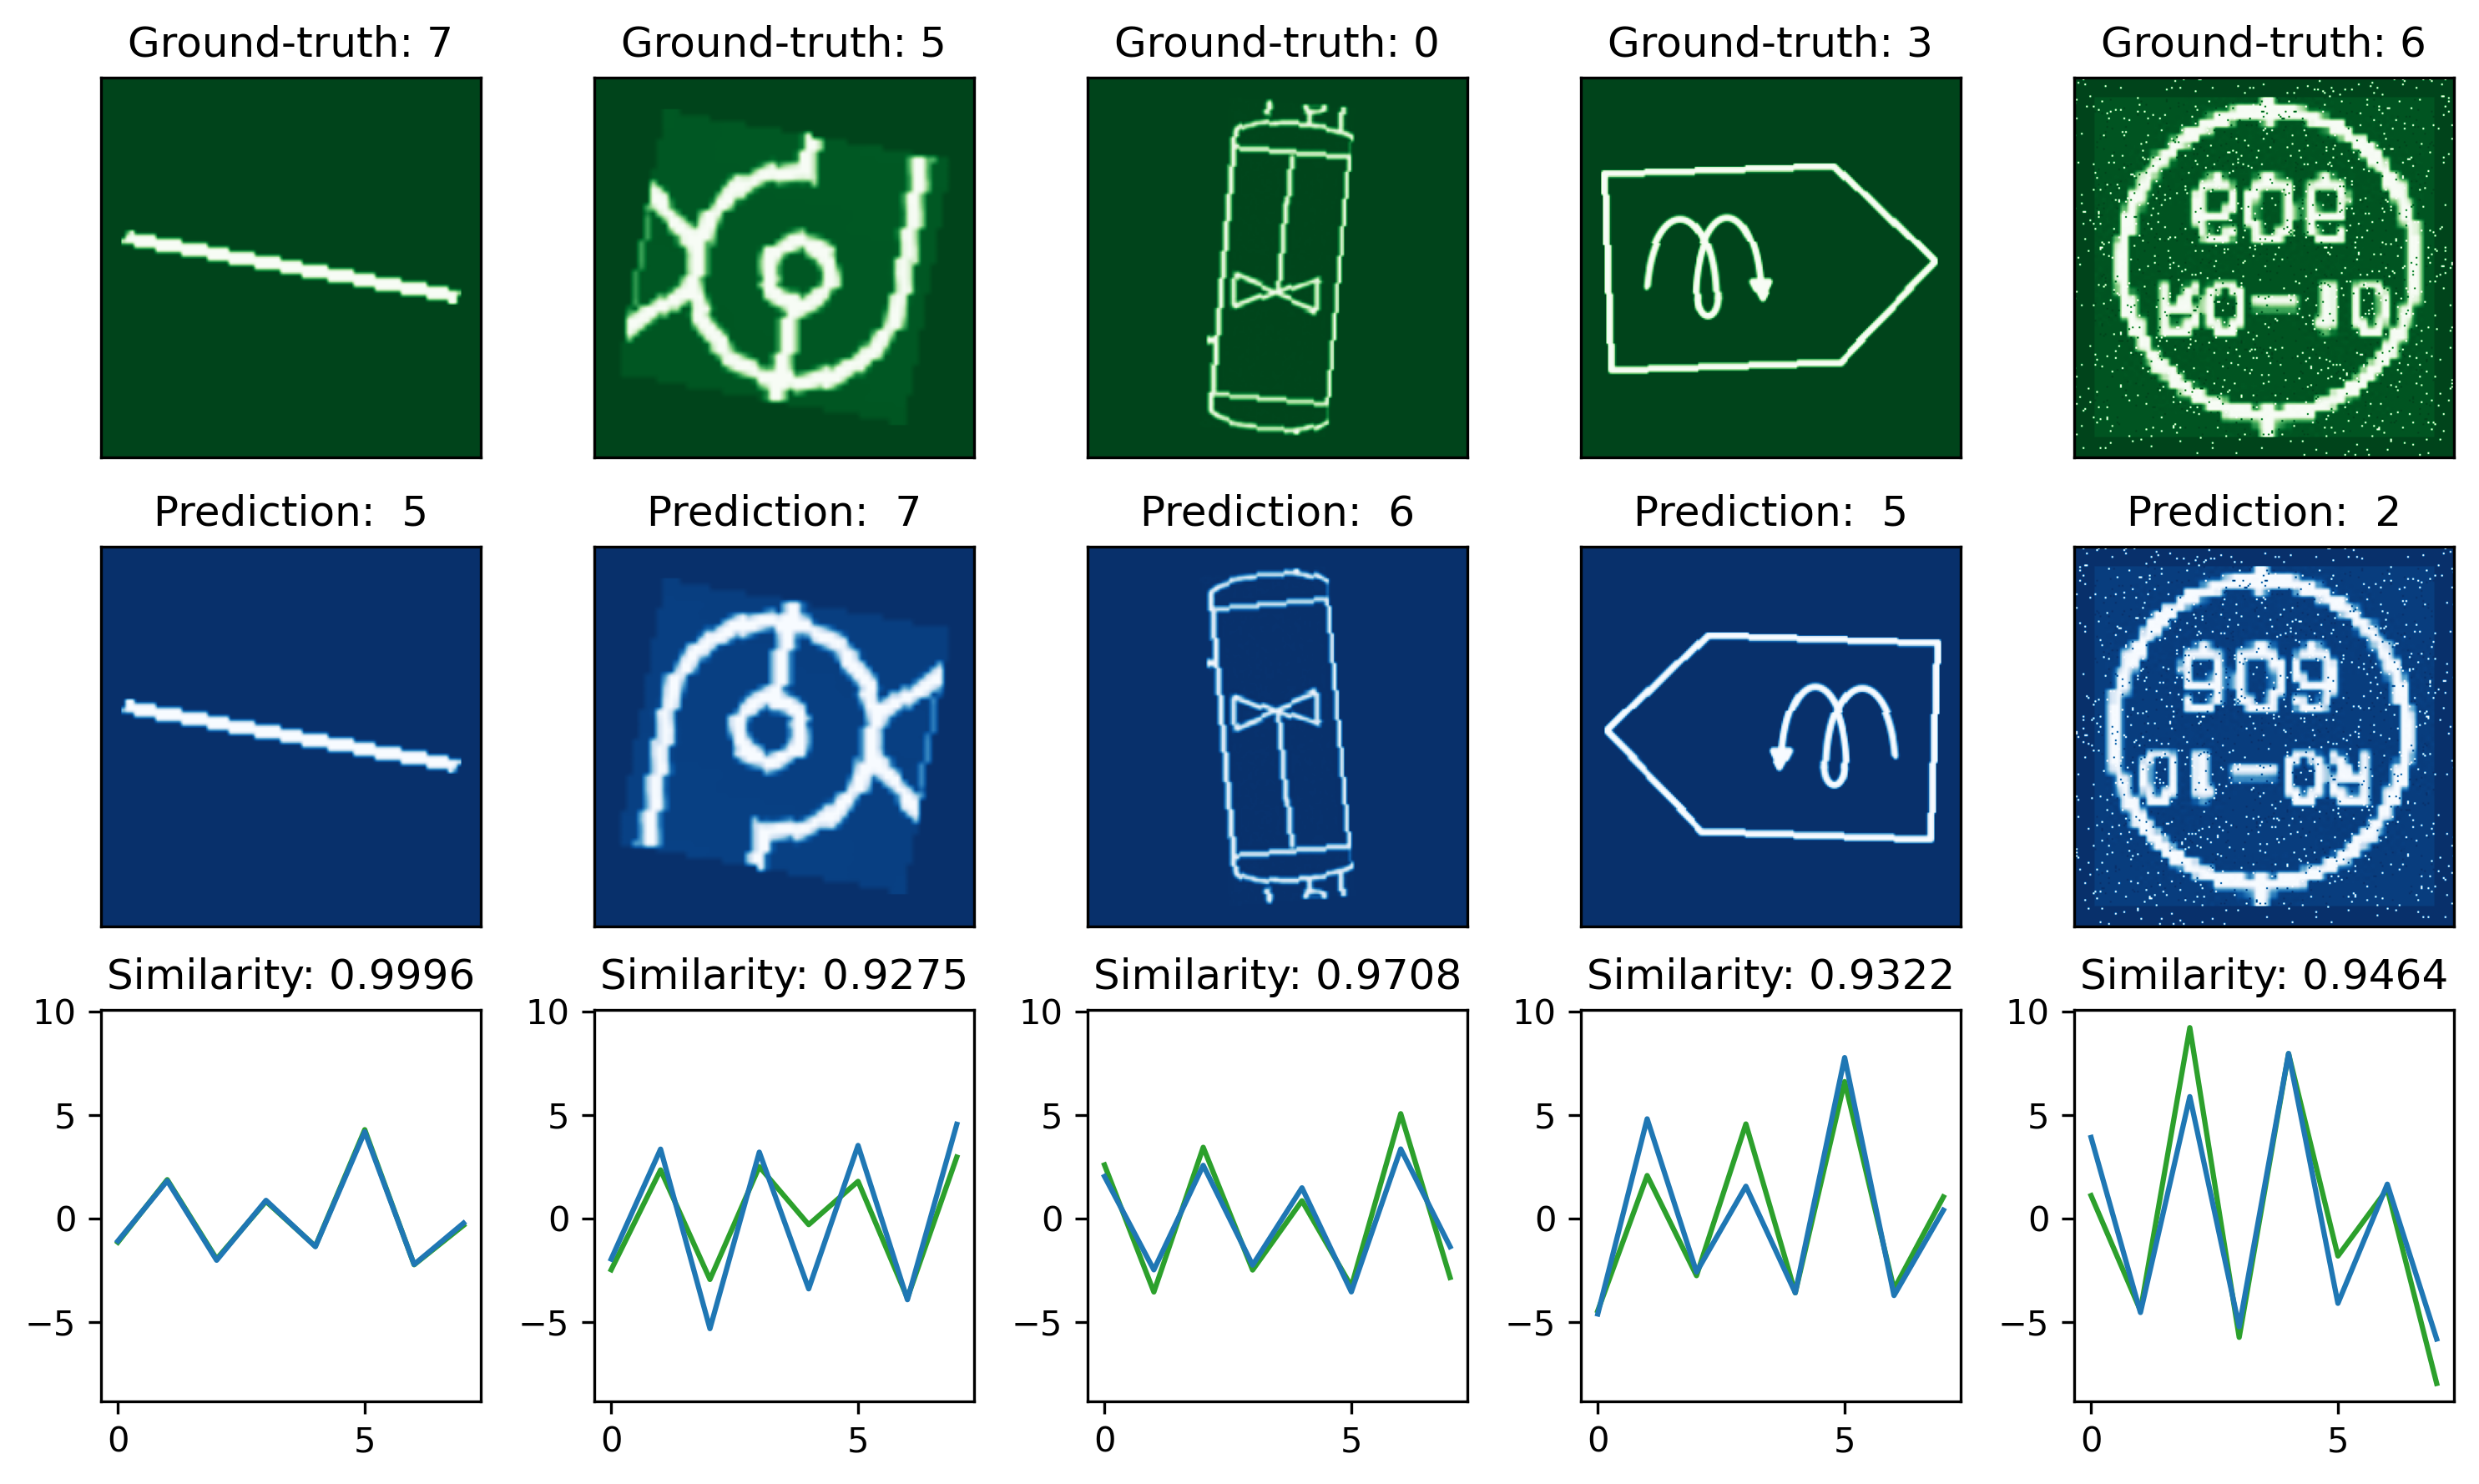

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=5, figsize=(10, 6), dpi=300)
for i in range(5):
    j = i+50
    similar_object = true_but_amgiuous[j]
    ax[0][i].imshow(similar_object["input_image"], cmap="Greens")
    ax[1][i].imshow(similar_object["rotated_image"], cmap="Blues")
    # embedding0_mean = np.mean(embeddings[0][0])
    # embedding1_mean = np.mean(embeddings[1][0])
    # ax[2][i].axhline(y=embedding0_mean, color="tab:green", linestyle="--")
    # ax[2][i].axhline(y=embedding1_mean, color="tab:blue", linestyle="--")
    ax[2][i].plot(similar_object["original_embedding"], label="original", color="tab:green")
    ax[2][i].plot(similar_object["rotated_embedding"], label="reoriented", color="tab:blue")
    ax[0][i].set(yticks=[], xticks=[])
    ax[1][i].set(yticks=[], xticks=[])
    ax[0][i].set(title=f"Ground-truth: {similar_object['true_label']}")
    ax[1][i].set(title=f"Prediction:  {similar_object['prediction']}")
    ax[2][i].set(title=f"Similarity: {similar_object['similarity']:.4f}")
for i in ax[2][1:]:
    i.sharey(ax[2][0])
plt.subplots_adjust(wspace=0.1, hspace=0.005)
fig.tight_layout()

In [16]:

print(classification_report(y_true, y_pred))
print(classification_report(y_true, y_pred_corrected))

              precision    recall  f1-score   support

           0       0.31      0.43      0.36      2081
           1       0.44      0.31      0.36      2095
           2       0.35      0.32      0.34      2074
           3       0.37      0.35      0.36      2071
           4       0.34      0.37      0.36      2041
           5       0.38      0.43      0.40      2089
           6       0.46      0.27      0.34      2097
           7       0.35      0.45      0.39      2060

    accuracy                           0.37     16608
   macro avg       0.38      0.37      0.36     16608
weighted avg       0.38      0.37      0.36     16608

              precision    recall  f1-score   support

           0       0.52      0.56      0.54      2081
           1       0.68      0.61      0.64      2095
           2       0.54      0.51      0.53      2074
           3       0.57      0.62      0.59      2071
           4       0.54      0.56      0.55      2041
           5       0.58 

In [ ]:
tu_delft_primary_colors_hex = {
    "Cyan": "#00A6D6",
    "White": "#FFFFFF",
    "Black": "#000000",
}
tu_delft_secondary_colors_hex = {
    "DarkBlue": "#0C2340",
    "Turquoise": "#00B8C8",
    "Blue": "#0076C2",
    "Purple": "#6F1D77",
    "Pink": "#EF60A3",
    "Raspberry": "#A50034",
    "Red": "#E03C31",
    "Orange": "#EC6841",
    "Yellow": "#FFB81C",
    "LightGreen": "#6CC24A",
    "DarkGreen": "#009B77",
}
tu_delft_primary_colors_RGB = {
    "Cyan": (0, 166, 214),
    "White": (255, 255, 255),
    "Black": (0, 0, 0),
}
tu_delft_secondary_colors_RGB = {
    "DarkBlue": (12, 35, 64),
    "Turquoise": (0, 184, 200),
    "Blue": (0, 118, 194),
    "Purple": (111, 29, 119),
    "Pink": (239, 96, 163),
    "Raspberry": (165, 0, 52),
    "Red": (224, 60, 49),
    "Orange": (237, 104, 66),
    "Yellow": (255, 184, 28),
    "LightGreen": (108, 194, 74),
    "DarkGreen": (0, 155, 119),
}

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred)
updated_conf_matrix = confusion_matrix(y_true, y_pred_corrected)
print(conf_matrix)

[[889  81 156 122 344  86 154 249]
 [181 650 120 156 160 396  33 399]
 [325  86 673 137 311 210 236  96]
 [199  72 128 715 139 317  55 446]
 [420 154 237 104 754 109 105 158]
 [178 200 156 283 110 894  45 223]
 [470  57 314 186 227 124 572 147]
 [190 181 118 242 146 210  50 923]]


Text(0.5, 0, 'Predicted')

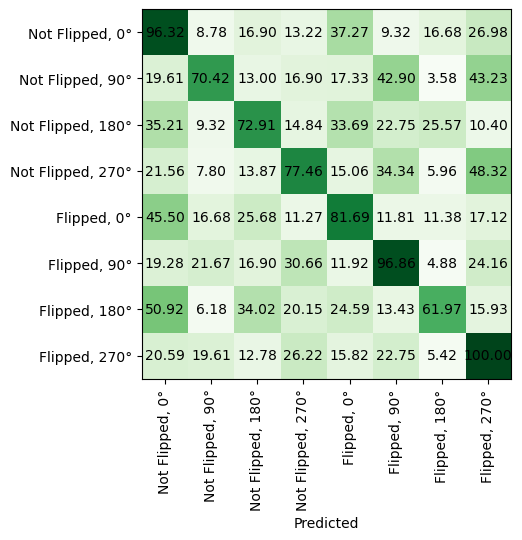

In [20]:
plt.imshow(conf_matrix/conf_matrix.max(), cmap="Greens")
plt.xticks(range(8), list(DepictionDataset.labels_map.values()), rotation=90)
plt.yticks(range(8), list(DepictionDataset.labels_map.values()))
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{conf_matrix[i, j]/conf_matrix.max()*100:.2f}', ha="center", va="center", color="black")
plt.xlabel("Predicted")

Text(0.5, 0, 'Predicted')

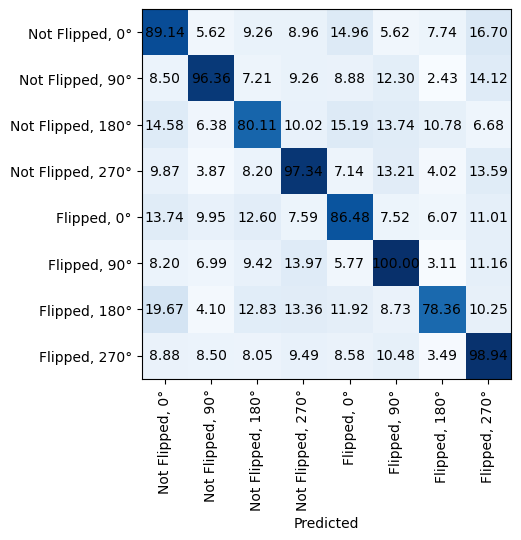

In [19]:
plt.imshow(updated_conf_matrix/updated_conf_matrix.max(), cmap="Blues")
plt.xticks(range(8), list(DepictionDataset.labels_map.values()), rotation=90)
plt.yticks(range(8), list(DepictionDataset.labels_map.values()))
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{updated_conf_matrix[i, j]/updated_conf_matrix.max()*100:.2f}', ha="center", va="center", color="black")
plt.xlabel("Predicted")